In [15]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# EDA - Exploratory Data Analysis

Image Shape = (96, 96, 3)


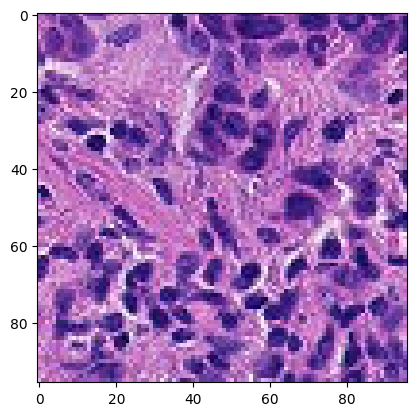

In [17]:
example_path = '../data/histopathologic-cancer-detection/train/0000da768d06b879e5754c43e2298ce48726f722.tif'
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

In [18]:
TRAIN_PATH = "../data/histopathologic-cancer-detection/train"
TEST_PATH = "../data/histopathologic-cancer-detection/test"

In [19]:
def train_img_path(id_str):
    return os.path.join(TRAIN_PATH, f"{id_str}.tif")

In [20]:
train_labels_df = pd.read_csv('../data/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/histopathologic-cancer-detection/train...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/histopathologic-cancer-detection/train...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/histopathologic-cancer-detection/train...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/histopathologic-cancer-detection/train...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/histopathologic-cancer-detection/train...


In [21]:
train_labels_df.shape

(220025, 3)

In [22]:
count_label = train_labels_df.groupby('label')['id'].count().reset_index().rename(columns={'id':'count'})

<Figure size 1500x700 with 0 Axes>

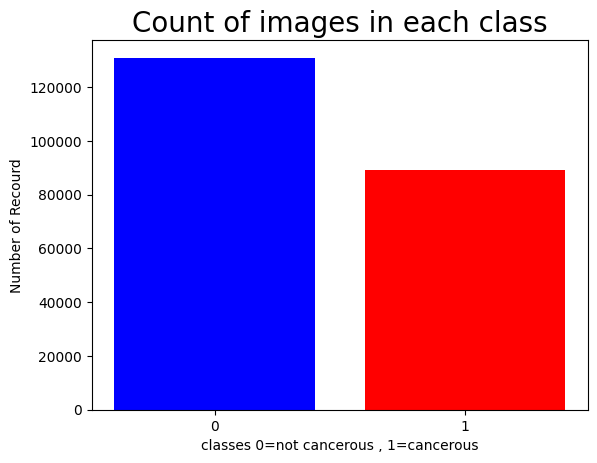

In [23]:
plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
ax.bar(count_label['label'], count_label['count'], color=['blue','red'])

plt.xlabel('classes 0=not cancerous , 1=cancerous')
plt.ylabel('Number of Recourd')
plt.title('Count of images in each class', fontsize=20)
plt.show()

In [24]:
train_labels_df['label'].value_counts(normalize = True)

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

In [25]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


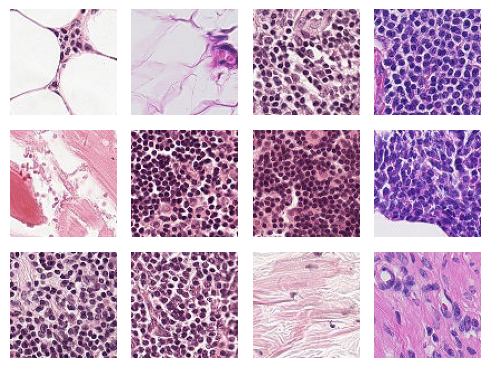

In [26]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


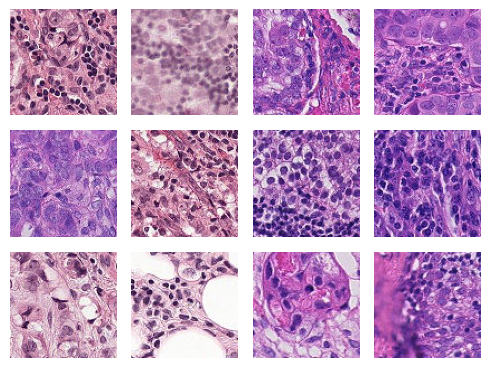

In [27]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

# Architecture model

In [28]:
test_ids = [filename[:-4] for filename in os.listdir(TEST_PATH)]
test_filenames = [os.path.join(TEST_PATH, filename) for filename in os.listdir(TEST_PATH)]
test_df = pd.DataFrame()
test_df['id'] = test_ids
test_df['filename'] = test_filenames

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96),
    color_mode='rgb',
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    validate_filenames = False,
    seed = 123

)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96),
    color_mode='rgb',
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    validate_filenames = False,
    seed = 123 
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 123
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.
Found 57458 non-validated image filenames.


In [30]:
# VGGNet

def conv_pool_layer(n_conv,model_input):
    for i in range(n_conv):
        x = tf.keras.layers.Conv2D(filters=50,
                               kernel_size=(3,3),
                               strides=2,
                               padding='same',
                               activation='relu')(model_input)
    x = tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        strides=None,
        padding='same'
    )(x)
    return x

def VGGNet(input_shape=(96,96,3)):
    # Define the input as a tensor
    X_input = tf.keras.layers.Input(input_shape)
    # Hidden layers
    x = tf.keras.layers.Conv2D(filters=100,
                               kernel_size=(3,3),
                               strides=1,
                               padding='same',
                               activation='relu')(X_input)
    x = conv_pool_layer(n_conv=2,model_input=x)
    x = conv_pool_layer(n_conv=2,model_input=x)
    x = conv_pool_layer(n_conv=3,model_input=x)
    x = conv_pool_layer(n_conv=3,model_input=x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # Output Layer
    output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    # Create model
    model = tf.keras.models.Model(inputs = X_input, outputs = output)
    return model

model = VGGNet()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 100)    │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 50)     │        45,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 50)       │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 50)       │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,317 (2.89 MB)

 Trainable params: 758,317 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None


# Model deployment

In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred, beta=1):
    y_pred = tf.math.sigmoid(y_pred)
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + K.epsilon())
    return K.mean(f1)

In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score],
              )

In [33]:
steps_per_epoch = len(train_generator) 

In [34]:
val_steps_per_epoch = len(validation_generator)

# Train model

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = val_steps_per_epoch,
    epochs = 15
)

Epoch 1/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 971s 177ms/step - accuracy: 0.8925 - auc: 0.9556 - f1_score: 0.3037 - loss: 0.2631 - val_accuracy: 0.8941 - val_auc: 0.9618 - val_f1_score: 0.3057 - val_loss: 0.2573
Epoch 2/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 693s 126ms/step - accuracy: 0.9004 - auc: 0.9621 - f1_score: 0.3031 - loss: 0.2433 - val_accuracy: 0.9066 - val_auc: 0.9650 - val_f1_score: 0.3024 - val_loss: 0.2320
Epoch 3/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 730s 133ms/step - accuracy: 0.9104 - auc: 0.9684 - f1_score: 0.3051 - loss: 0.2221 - val_accuracy: 0.9100 - val_auc: 0.9668 - val_f1_score: 0.3033 - val_loss: 0.2276
Epoch 4/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 738s 134ms/step - accuracy: 0.9179 - auc: 0.9725 - f1_score: 0.3030 - loss: 0.2065 - val_accuracy: 0.9146 - val_auc: 0.9683 - val_f1_score: 0.3020 - val_loss: 0.2198
Epoch 5/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 748s 136ms/step - accuracy: 0.9247 - auc: 0.9758 - f1_score: 0.3043 - loss: 0.1930 - val_accuracy: 0.9037 - val_auc: 0.9714 - 

In [37]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)
    plt.figure(figsize=[14,4])
    n = int(len(h.keys()) / 2)
    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()
    plt.tight_layout()
    plt.show()

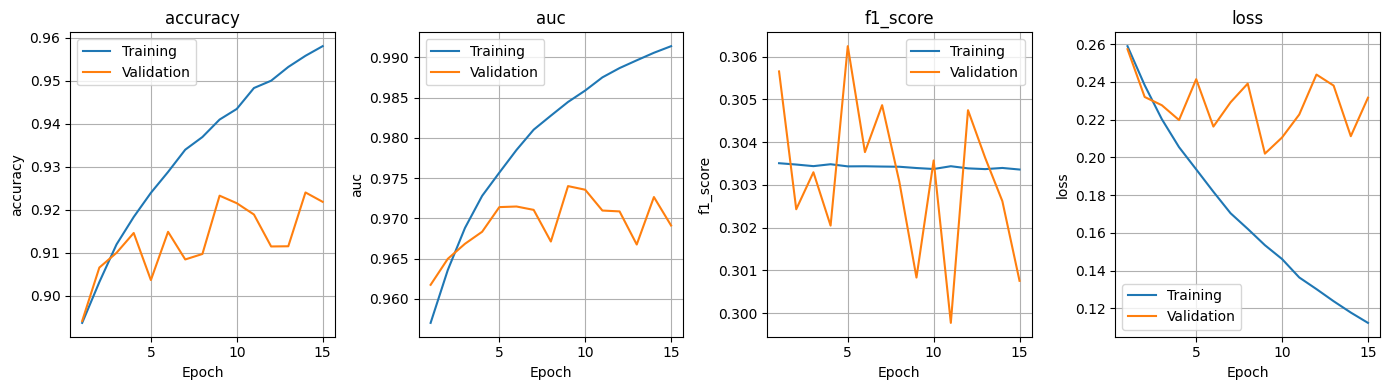

In [38]:
history_modelrestnet = merge_history([history])
vis_training(history_modelrestnet)

# Test results

In [39]:
y_pred = model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 677s 377ms/step


In [40]:
y_pred

array([[9.7492480e-01],
       [9.5918179e-01],
       [1.8042390e-01],
       ...,
       [5.5915612e-04],
       [1.3807474e-01],
       [2.1328375e-01]], dtype=float32)

In [41]:
test_df['pred'] = y_pred.flatten()

In [42]:
test_df['label'] = test_df['pred'] >= 0.5
test_df['label'] = test_df['label'].astype(int)

In [43]:
test_df[['id','label']].sample(3)

,id,label
40026,b25117bfe9502530fc022ac4a708946e55f12b76,0
8836,27a59157c0f3b15933ae6b76921129d135d3c20a,0
9931,2c328a46d06213652c5717dceb79f962a8c0d7e9,0


In [44]:
test_df[['id','label']].to_csv('../data/submission.csv',index=None)

Image Shape = (1048, 1054, 4)


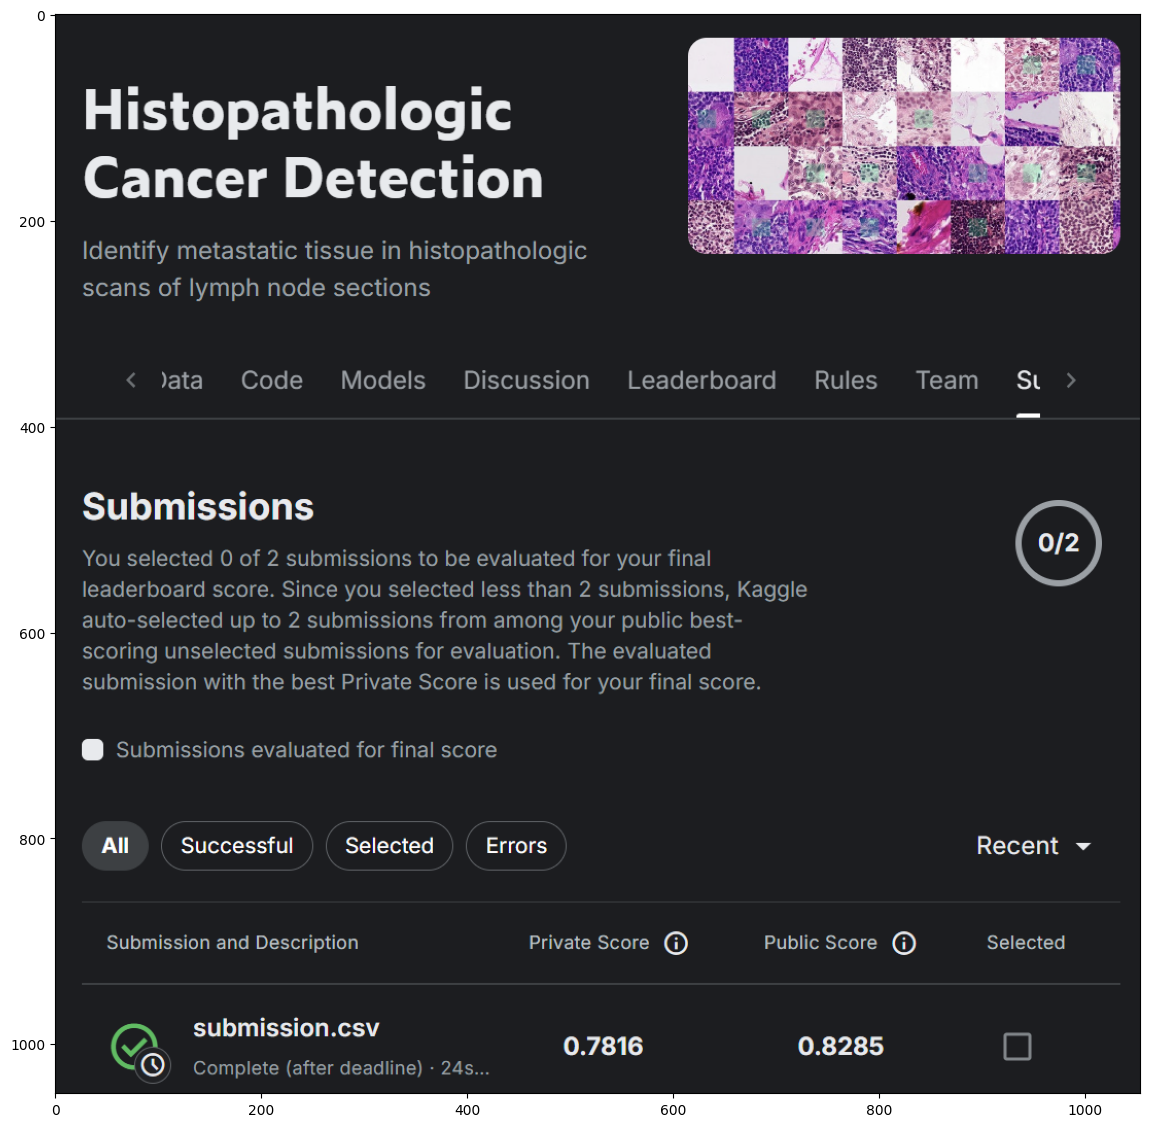

In [48]:
example_path = '../notebook/kaggle_score.png'
example_img = Image.open(example_path)
example_array = np.array(example_img)
plt.figure(figsize=[14,20])
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()